In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from scipy.fftpack import fft
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from sklearn.metrics.pairwise import cosine_similarity
import scienceplots
import matplotlib as mpl
from copy import deepcopy
mpl.rcParams['figure.dpi'] = 300

In [2]:
import lib.python.lib_FHRR_Loihi as lib
import lib.python.utility as util
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

In [3]:
def plot_multiple_box_plots(data_sets, x_title="X Values", y_title="Y Values", title="", show_box_plots=True, label_prefix="", y_limits=None, x_limits=None, figsize=(10, 6), show_outliers=False):
    """
    Plots multiple sets of customized black and white box plots for each x value with multiple y values,
    indicates outliers, and adds a line graph connecting the means of y values for each dataset.

    Parameters:
    data_sets (list of dicts): List of dictionaries, each containing 'x_values', 'y_values', and 'title' keys.
                               Each dictionary represents a dataset.
    x_title (str): Label for the x-axis.
    y_title (str): Label for the y-axis.
    title (str): Overall title of the plot.
    show_box_plots (bool): If True, display box plots. If False, only plot the means.
    y_limits (tuple): Optional parameter to set the y-axis limits. Should be a tuple (y_min, y_max).
    """
    fig, ax = plt.subplots(figsize=figsize)

    plt.rcParams["figure.figsize"] = [7.00, 7.50]
    plt.rcParams["figure.autolayout"] = True

    colors = ['black', 'blue', 'green', 'red', 'purple', 'orange']  # Add more colors as needed

    for idx, data_set in enumerate(data_sets):
        x_values = data_set['x_values']
        y_values = data_set['y_values']
        dataset_title = data_set.get('title', f'Dataset {idx + 1}')
        color = colors[idx % len(colors)]
        
        if show_box_plots:
            # Create the box plot
            boxplot = ax.boxplot(y_values, positions=x_values, patch_artist=False, showmeans=True, meanline=True,
                                 showfliers=show_outliers,
                                 flierprops=dict(marker='x', color=color, markersize=5), boxprops=dict(color=color),
                                 whiskerprops=dict(color=color), capprops=dict(color=color), medianprops=dict(color=color))
        
        # Calculate means of y values
        means = [np.mean(y) for y in y_values]
        
        # Plot the line graph connecting the means
        label_txt = label_prefix + f' {dataset_title}'
        ax.plot(x_values, means, color=color, linestyle='-', marker='o', markerfacecolor='none', label=label_txt)

    # Set the x-axis labels
    ax.set_xticks(x_values)
    ax.set_xticklabels([str(x) for x in x_values])

    # Set labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)

    if x_limits is not None:
        ax.set_xlim(x_limits)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()


In [4]:
# Encoding
def rate_encode(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)

    # Generate Poisson spike trains
    spike_trains = np.random.binomial(1, normalized_values, (duration, len(values)))
    return spike_trains, min_val, max_val

# Decoding
def rate_decode(spike_trains, duration, min_val, max_val):
    # Count spikes and average over duration
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration

    # Denormalize values back to original range
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values

# Encoding Exact
def rate_encode_exact(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    
    # Generate spike trains based on the value
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        num_spikes = int(value * duration)
        spike_indices = np.linspace(0, duration-1, num_spikes, dtype=int)
        spike_trains[spike_indices, i] = 1
    
    return spike_trains, min_val, max_val

# Decoding Exact
def rate_decode_exact(spike_trains, duration, min_val, max_val):
    # Count spikes and average over duration
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration

    # Denormalize values back to original range
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values

# Encoding
def latency_encode(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    
    # Generate spike trains based on latency
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        spike_time = int((1 - value) * (duration - 1))
        spike_trains[spike_time, i] = 1
    return spike_trains, min_val, max_val

# Decoding
def latency_decode(spike_trains, duration, min_val, max_val):
    # Find the first spike time for each neuron
    first_spike_times = np.argmax(spike_trains, axis=0)
    
    # Normalize back to [0, 1] range
    normalized_values = 1 - (first_spike_times / (duration - 1))
    
    # Denormalize values back to original range
    original_values = normalized_values * (max_val - min_val) + min_val
    return original_values

In [5]:
# Example usage
values = np.array([10, 0.5, 0.81, 0.3])  # Example d-dimensional array
duration = 100

# Encode
spike_trains, min_val, max_val = rate_encode(values, duration)
# print("Spike Trains:\n", spike_trains)

# Decode
decoded_values = rate_decode(spike_trains, duration, min_val, max_val)
print("Decoded Values:\n", decoded_values)

Decoded Values:
 [10.     0.591  0.591  0.3  ]


In [23]:
# Example usage
values = np.array([10, 0.5, 0.81, 0.3])  # Example d-dimensional array
duration = 100

# Encode
spike_trains, min_val, max_val = latency_encode(values, duration)
print("Spike Trains:\n", spike_trains)

# Decode
decoded_values = latency_decode(spike_trains, duration, min_val, max_val)
print("Decoded Values:\n", decoded_values)

Spike Trains:
 [[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0.

In [7]:
# dimension_list = [i for i in range(10, 100, 10)]
# dimension_list = [10, 50, 100, 200, 500, 1000, 5000, 10000]
dimension_list = [10, 100, 1000, 10000, 100000]

In [8]:
sim_time = 2000
v_th = 120
rv_repeat = 1

In [9]:
full_rslt = []

sim_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        error_percentage = 0.0498 # To make v_th=120 for a nice figure
        # 0.06283 = 2 pi * 1%
        # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
        lib.set_params_manual(v_th, sim_time)
        
        encoder  = lib.FHRR_Encoder(vec = rv1)
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
        
        raw_rslt  = decoder.get_decoded_value()
        
        decoder.stop()
    
        rslt = cosine_similarity([rv1], [raw_rslt])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
full_rslt.append( {'title':'Our Algorithm', 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


In [10]:
sim_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        # Encode
        spike_trains, min_val, max_val = rate_encode(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Decode
        decoded_values = rate_decode(spike_trains, sim_time, min_val, max_val)
    
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
full_rslt.append( {'title':'Rate Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


In [11]:
sim_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        # Encode
        spike_trains, min_val, max_val = rate_encode_exact(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Decode
        decoded_values = rate_decode_exact(spike_trains, sim_time, min_val, max_val)
    
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
# full_rslt.append( {'title':'Rate Encoding (exact)', 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


In [12]:
sim_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        # Encode
        spike_trains, min_val, max_val = latency_encode(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Decode
        decoded_values = latency_decode(spike_trains, sim_time, min_val, max_val)
    
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
# full_rslt.append( {'title':'Latency Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


In [13]:
sim_rslt = []

''' Calibration to find how many spikes will I get for the Max value. Depends on the timesteps, Vth'''

rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]
'''
But calibration is mandatory as after the calibration calculation, it is just a scaling of the spike count vector, which will not 
affect the cosine similarity.
'''

for dimensions in tqdm(dimension_list):
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        encoder  = lib.FHRR_Encoder(vec = rv1)
        decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
        
        spike_count = decoder.get_spike_count()
        
        decoder.stop()

        decoded_vec = spike_count / max_count * (2*math.pi)
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
full_rslt.append( {'title':'Rate Encoding (LIF)', 'x_values':dimension_list, 'y_values':sim_rslt} )

100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


In [14]:
full_rslt

[{'title': 'Our Algorithm',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[0.9999449615930509],
   [0.9999060091679755],
   [0.9999172788015507],
   [0.9999187496640549],
   [0.9999223122745877]]},
 {'title': 'Rate Encoding',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[0.9999780647548651],
   [0.9998913056045671],
   [0.9998815787667602],
   [0.9998718259647148],
   [0.9998745360098167]]},
 {'title': 'Rate Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[0.9998784321469232],
   [0.999932093594422],
   [0.9999168966598206],
   [0.9999146522298272],
   [0.9999157445290083]]}]

In [15]:
full_rslt_log = deepcopy(full_rslt)

In [16]:
for it in full_rslt_log:
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

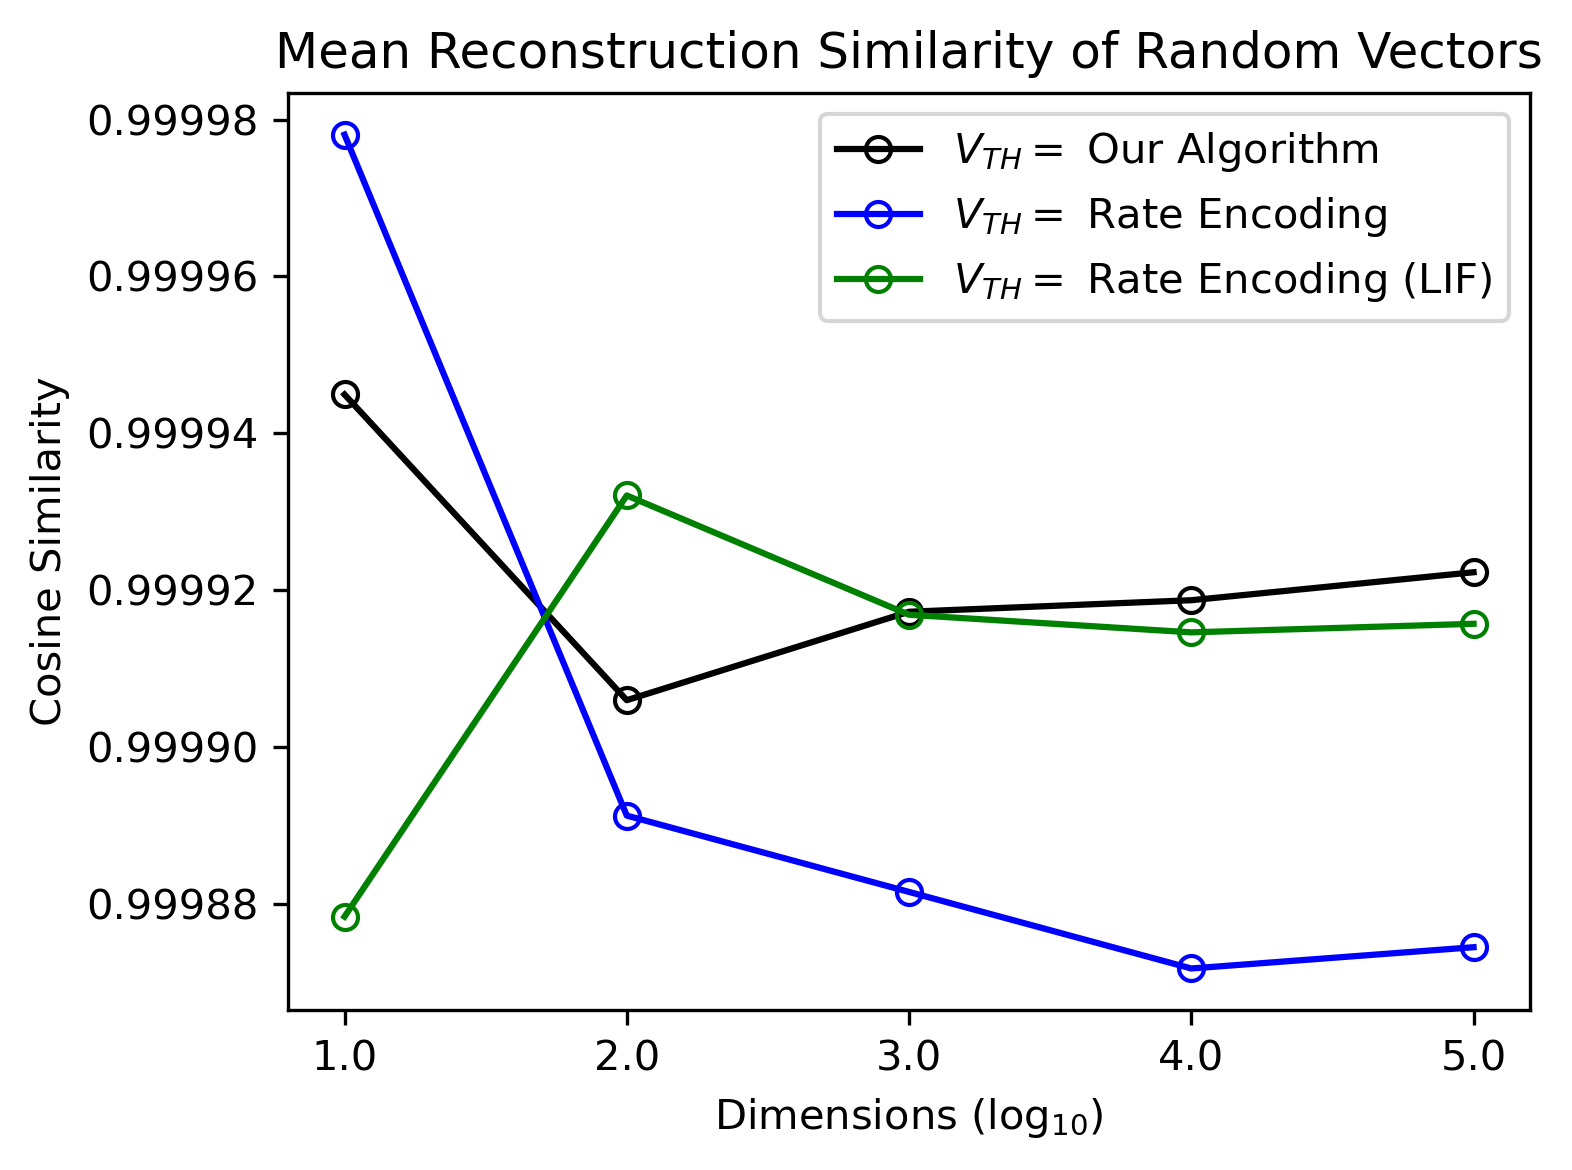

In [22]:
plot_multiple_box_plots(full_rslt_log, "Dimensions (log$_{10}$)", "Cosine Similarity", "Mean Reconstruction Similarity of Random Vectors", False, label_prefix="$V_{TH} = $", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))

### Test the LIF Rate encoding

In [ ]:
sim_time = 2000
v_th = 120
rv_repeat = 1

lib.set_params_manual(v_th, sim_time)
dimensions = 1000

In [ ]:
rv1 = np.random.uniform(0, 2 * np.pi, dimensions)

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

raw_rslt  = decoder.get_decoded_value()

spike_count = decoder.get_spike_count()

decoder.stop()

In [ ]:
rslt = cosine_similarity([rv1], [raw_rslt])[0][0]

In [ ]:
rslt

In [ ]:
rate_decode_vec = (spike_count / sim_time) * (2*math.pi)

In [ ]:
cosine_similarity([rv1], [rate_decode_vec])[0][0]

### Calibration signal

In [ ]:
rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]

In [ ]:
rv1 = np.random.uniform(0, 2 * np.pi, dimensions)

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

raw_rslt  = decoder.get_decoded_value()

spike_count = decoder.get_spike_count()

decoder.stop()

In [ ]:
decoded_vec = spike_count / max_count * (2*math.pi)

In [ ]:
cosine_similarity([rv1], [decoded_vec])[0][0]

In [ ]:
cosine_similarity([rv1], [spike_count])[0][0]

## LIF Rate Encoding